<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2021-AC215/' target='_blank'><strong><font color="#A41034">AC215: Advanced Practical Data Science, MLOps</font></strong></a></h1>

# **<font color="#A41034">Exercise 4 - Language Models</font>**

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Competition</font>**

### **<font color="#f03b20">Due Date: Check Canvas</font>**

#### **[Join Competition](https://www.kaggle.com/t/a8ec65d928b645e596a071527b3b3d33)**

#### **[View Leaderboard](https://www.kaggle.com/c/ac215-fall-2021/leaderboard)**

Now your task for this exercise is to build the best language model capable of classifying **abstracts** of Astrophysics papers taken from ArXiv. The labels for the classification dataset are as following: 

**Lables:**

* 0 = astro-ph.SR - Solar and Stellar Astrophysics
* 1 = astro-ph.GA - Astrophysics of Galaxies
* 2 = astro-ph.CO - Cosmology and Nongalactic Astrophysics

A good start for this exercise would be to start with some pre-trained language models. Since the text in Astrophysics is very domain specific, there is only so much accuracy a pre-trained language model can acheive. An idea to build a better language model will be to finetune the language model on a lot of unlabled abstracts from the Astrophysics papers. Then use this finetuned model for classification.

Here are some techniques you can try:

* Transfer Learning using different pre-trained language models from [HuggingFace](https://huggingface.co/models)
* Finetune a language model using the the abstract texts provided (`abstracts_train.txt` & `datasets/abstracts_validate.txt`). Here is a reference [link](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/language-modeling) on how to finetune a language model
* Any other modeling techniques you feel appropriate

#### **Exercise Requirements:**
* At a minimum beat the public leaderboard score of **0.64** (benchmark submission)



<br>

**Remember to upload your submission files to Kaggle and also submit your notebook to Canvas at the end.**

<br>

**<font color="#f03b20">The leaderboard for this competition will be computed based on `hidden` test set.</font>**

## **<font color="#A41034">Setup Notebook</font>**

**Installs**

In [1]:
!pip install transformers datasets

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 285 kB 47.3 MB/s 
     |████████████████████████████████| 3.3 MB 40.5 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 125 kB 52.2 MB/s 
     |████████████████████████████████| 243 kB 46.2 MB/s 
     |████████████████████████████████| 1.3 MB 37.6 MB/s 
     |████████████████████████████████| 160 kB 60.7 MB/s 
     |████████████████████████████████| 271 kB 42.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Imports**

In [2]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, GPT2Config

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow. Make sure you start this exercise early, as training might take time.

In [4]:
!nvidia-smi

Wed Oct 13 21:25:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [5]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  if isinstance(model,TFBertForSequenceClassification):
    model.save_weights(os.path.join(experiment_name,model_name+".h5"))
  else:
    # Save the enitire model (structure + weights)
    model.save(os.path.join(experiment_name,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(experiment_name,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "name": model.name,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [6]:
start_time = time.time()
# Dowload the dataset
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/arxiv_astronmy_competition.zip", 
              base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.02483716408411662


#### **Load & EDA**

In [128]:
# Your Code Here
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

num_classes = len(set(train_df['label']))
print("Number of classes:", num_classes)
print("Labels:", set(train_df.label))


train_x = train_df.abstract
train_y = train_df.label
test_x = test_df.abstract
print("train_x count:",len(train_x))
print("train_y count:",len(train_y))
print("test_x count:",len(test_x))
print("train_y Label counts:",np.unique(train_y, return_counts=True))


Number of classes: 3
Labels: {0, 1, 2}
train_x count: 1575
train_y count: 1575
test_x count: 525
train_y Label counts: (array([0, 1, 2]), array([526, 527, 522]))


In [8]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(train_x)-1, size=5)
for i,data_idx in enumerate(data_samples):
  print("Label:",train_y[data_idx],", Text:",train_x[data_idx])

Label: 1 , Text:   The deuterium fractionation in starless cores gives us a clue to estimate
their lifetime scales, thus allowing us to distinguish between different
dynamical theories of core formation. Cores also seem to be subject to a
differential N2 and CO depletion which was not expected from models. We aim to
make a survey of 10 cores to estimate their lifetime scales and depletion
profiles in detail. After L183, in Serpens, we present the second cloud of the
series, L1512 in Auriga. To constrain the lifetime scale, we perform chemical
modeling of the deuteration profiles across L1512 based on dust extinction
measurements from near-infrared observations and non-local thermal equilibrium
radiative transfer with multiple line observations of N2H+, N2D+, DCO+, C18O,
and 13CO, plus H2D+ (1$_{10}$--1$_{11}$). We find a peak density of
1.1$\times$10$^5$ cm$^{-3}$ and a central temperature of 7.5$\pm$1 K, which are
respectively higher and lower compared with previous dust emission stud

## **<font color="#A41034">Build Data Pipelines</font>**

#### **Split Data** 
We split train data into train and validation by randomly selecting 20% as the validation set.

In [9]:
# Your Code Here
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_x, train_y, test_size=validation_percent)
train_x = train_x.values
train_y = train_y.values
validate_x = validate_x.values
validate_y = validate_y.values
print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 1260
validate_x count: 315


#### **Text Vectorization**

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)

Since machines cannot read text directly, we need to transform text into numerical vectors. Here is a common procedure of generating Text Vectors.
- Standardize each sample (usually lowercasing + punctuation stripping)
- Split each sample into substrings (usually words)
- Index tokens (associate a unique int value with each token)
- Transform each sample using this index, either into a vector of ints or a dense float vector

In [10]:
# Text Vectorization
def standardize_text(input_text):
  # Convert to lowercase
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

In [13]:
sequence_length = max([len(x) for x in train_x])
sequence_length

1927

In [47]:
# Define parameters for TextVectorization
# max_token controls the vocabulary size based on frequency
# output_sequence_length controls the length of each vector. If set, 
# the initial vector would be padded or truncated to match the specified length.

max_features = 17000
sequence_length = 2000

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Create the vocabulary of entire dataset
text_data = tf.data.Dataset.from_tensor_slices(train_x)

# Generate Text Vector
start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Execution time (mins) 0.0027617732683817547
Vocabulary Size: 15942


In [41]:
# Check Vocabulary : 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

Vocabulary: ['', '[UNK]', 'the', 'of', 'and', 'in', 'a', 'to', 'we', 'with', 'is', 'that', 'for', 'are', 'from', 'by', 'at', 'on', 'this', 'as']
Vocabulary Size: 15942


In [42]:
# Test our text vectorizer
test_text = train_x[data_samples[0]]
print(test_text)
test_text_vector = text_vectorizer([test_text])
print("Shape:",test_text_vector.shape)
# display only the first 20 tokens of the sample 0
print(test_text_vector[0,:20])

  Understanding the role of mergers in galaxy formation is one of the most
outstanding problems in extragalactic astronomy. While we now have an idea for
how the merger fraction evolves at redshifts z < 3, converting this merger
fraction into merger rates, and therefore how many mergers an average galaxy
undergoes during its history, is still uncertain. The main reason for this is
that the inferred number of mergers depends highly upon the time-scale
observational methods are sensitive for finding ongoing or past mergers. While
there are several theoretical and model-based estimates of merger times, there
is currently no empirical measure of this time-scale. We present the first
observationally based measurement of merger times utilising the observed
decline in the galaxy major merger fraction at z < 1.2 based on > 20,000
galaxies in the Extended Groth Strip and COSMOS surveys. Using a new
methodology described in this paper, we determine how long a galaxy remains
identifiable as a mer

#### **Create TF Datasets**

In [43]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Converts y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_y, num_classes = num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_y, num_classes = num_classes, dtype='float32')

# Vetorize Text
def vectorize_text(text, label=None):
  text = tf.expand_dims(text,-1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

In [44]:
#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)


train_data <PrefetchDataset shapes: ((None, 2000), (None, 3)), types: (tf.int64, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 2000), (None, 3)), types: (tf.int64, tf.float32)>


## **<font color="#A41034">Build Text Classification Models</font>**

#### **Simple Fully Connected Network**

* We will start with a simple fully connected neural network. 
* In this model, each layer is a dense layer
* Wer use activation function in  the hidden layers as ReLU. 
* Since our task is a multiclass classification problem, we use softmax as the activation function in the output layer.

In [19]:
# Your Code Here
def build_simple_fcn(num_classes, sequence_length):
  # Set the model name as
  model_name = 'simple_fcn'

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  hidden = keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

In [20]:
# Create an experiment
create_experiment()

Model: "simple_fcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2049024   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 3,887,619
Trainable params: 3,887,619
Non-trainable params: 0
______________________________________________

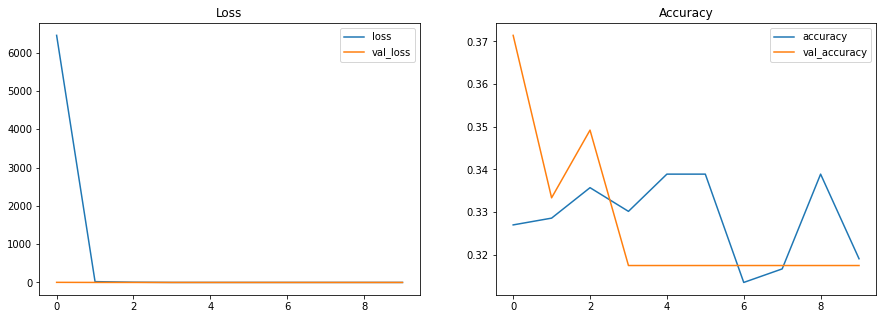

10/10 [==============================] - 0s 3ms/step - loss: 1.1000 - accuracy: 0.3175
[1.0999512672424316, 0.3174603283405304]


In [21]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn(num_classes, sequence_length)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

#### **Simple Fully Connected Network with Embedding**

* Let's add an embedding layer to the previous simple fully connected network

In [22]:
def build_simple_fcn_with_emb(num_classes, sequence_length, vocab_size, embedding_dim):
  #Set the model name as
    model_name = 'simple_fcn_emb'

    # Model input
    model_input = keras.layers.Input(shape=(sequence_length))

    hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(model_input)
    hidden = keras.layers.Flatten()(hidden)
    hidden = keras.layers.Dense(1024, activation="relu")(hidden)
    hidden = keras.layers.Dense(512, activation="relu")(hidden)

    # Output Layer
    output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

    # Create model
    model = Model(inputs=model_input, outputs=output, name=model_name)

    return model

In [23]:
# Create an experiment
create_experiment()

Model: "simple_fcn_emb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1594200   
_________________________________________________________________
flatten (Flatten)            (None, 200000)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              204801024 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 206,921,563
Trainable params: 206,921,563
Non-trainable params: 0
______________________________________

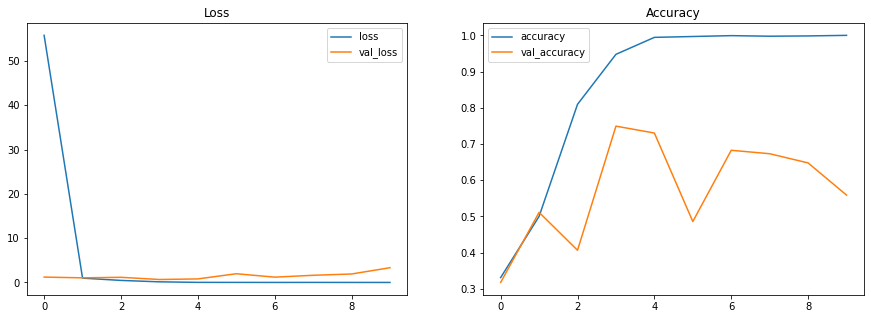

10/10 [==============================] - 0s 9ms/step - loss: 3.3247 - accuracy: 0.5587
[3.3247392177581787, 0.5587301850318909]


In [25]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn_with_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

#### **Conv1D Network with Embedding**

* Next let us use Conv1D layers to build the model

In [26]:
def build_conv1d_emb(num_classes,sequence_length, vocab_size, embedding_dim):
  # Set the model name as
  model_name = 'conv1d_emb'

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  # Embedding Layer
  hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(model_input)

  # Conv1D + Global Max Pooling
  hidden = keras.layers.Conv1D(filters=256, kernel_size=5, padding="valid", activation="relu", strides=3)(hidden)
  hidden = keras.layers.GlobalMaxPooling1D()(hidden)

  # Dense Layer
  hidden = keras.layers.Dense(units=128, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

In [27]:
# Create an experiment
create_experiment()

Model: "conv1d_emb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1594200   
_________________________________________________________________
conv1d (Conv1D)              (None, 666, 256)          128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,755,739
Trainable params: 1,755,739
Non-trainable params: 0
______________________________________________

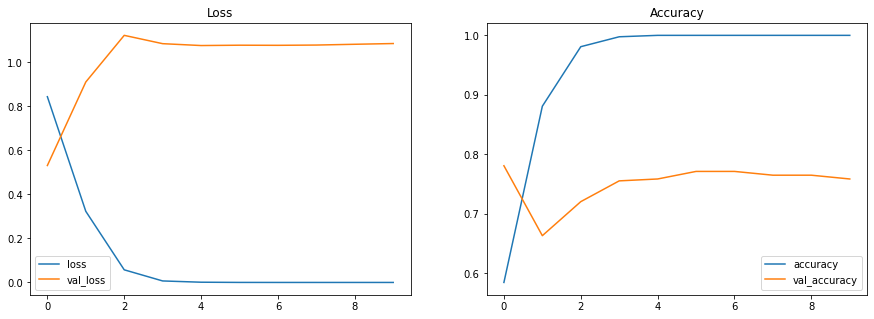

10/10 [==============================] - 0s 4ms/step - loss: 1.0857 - accuracy: 0.7587
[1.0857378244400024, 0.7587301731109619]


In [28]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_conv1d_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

#### **Conv1D Network with pretrained Embedding**

* Alternatively, we could initialize embeddings with pre-trained word embeddings.
* Specifically, let's try GloVe embeddings. GloVe stands for Global Vectors, which is an open-source project developed by Stanford. It contains pre-trained word representations in various sizes, including 50-dimensional, 100-dimensional, 200-dimensional, and 300-dimensional.

* In this model, we choose the 100d version.

[Reference](http://nlp.stanford.edu/projects/glove/)

#### **Prepare Embedding**

We need to prepare the pretrained embedding to use in our model

In [30]:
# Download Glove pretrained embeddings
download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", 
              base_path="embedding", extract=True)

In [31]:
EMBEDDING_FILE = os.path.join("embedding","glove.6B.100d.txt")

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Number of word vectors:",len(embeddings_index))

Number of word vectors: 400000


In [32]:
# View some word embeddings
sample_embeddings_words = list(embeddings_index.keys())[:10]
for word in sample_embeddings_words:
  print(word,":",embeddings_index[word][:5],", Shape:", embeddings_index[word].shape)

the : [-0.038194 -0.24487   0.72812  -0.39961   0.083172] , Shape: (100,)
, : [-0.10767  0.11053  0.59812 -0.54361  0.67396] , Shape: (100,)
. : [-0.33979  0.20941  0.46348 -0.64792 -0.38377] , Shape: (100,)
of : [-0.1529  -0.24279  0.89837  0.16996  0.53516] , Shape: (100,)
to : [-0.1897    0.050024  0.19084  -0.049184 -0.089737] , Shape: (100,)
and : [-0.071953  0.23127   0.023731 -0.50638   0.33923 ] , Shape: (100,)
in : [ 0.085703 -0.22201   0.16569   0.13373   0.38239 ] , Shape: (100,)
a : [-0.27086   0.044006 -0.02026  -0.17395   0.6444  ] , Shape: (100,)
" : [-0.30457 -0.23645  0.17576 -0.72854 -0.28343] , Shape: (100,)
's : [ 0.58854 -0.2025   0.73479 -0.68338 -0.19675] , Shape: (100,)


In [33]:
# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
oov = {}    
n_covered = 0
n_oov = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      n_oov += 1

text_coverage = (vocabulary_size-n_oov)/vocabulary_size
print("Text Coverage:",text_coverage)

print("Embedding Matrix, Shape" ,embedding_matrix.shape)

Text Coverage: 0.5930247145903902
Embedding Matrix, Shape (17000, 100)


In [34]:
# Test oov
print(embeddings_index.get('covid'))

None


In [35]:
def build_conv1d_pretrained_emb(num_classes,sequence_length, vocab_size, embedding_dim):
  # Set the model name as
  model_name = 'conv1d_pretrained_emb'

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  # Embedding Layer, with pre-trained weights
  hidden = keras.layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Load pre-trained weights
                            trainable=False, # Set Trainable to False
                            name="embedding")(model_input)

  # Conv1D + Global Max Pooling
  hidden = keras.layers.Conv1D(filters=256, kernel_size=5, padding="valid", activation="relu", strides=3)(hidden)
  hidden = keras.layers.GlobalMaxPooling1D()(hidden)

  # Dense Layer
  hidden = keras.layers.Dense(units=128, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

In [36]:
# Create an experiment
create_experiment()

Model: "conv1d_pretrained_emb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1700000   
_________________________________________________________________
conv1d (Conv1D)              (None, 666, 256)          128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,861,539
Trainable params: 161,539
Non-trainable params: 1,700,000
_____________________________

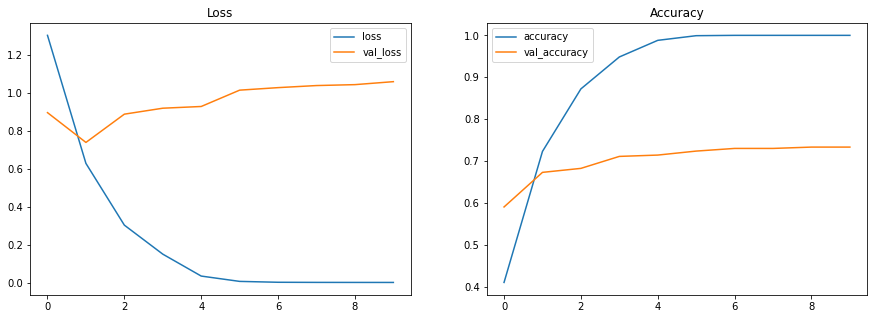

10/10 [==============================] - 0s 4ms/step - loss: 1.0580 - accuracy: 0.7333
[1.0579866170883179, 0.7333333492279053]


In [48]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_conv1d_pretrained_emb(num_classes, sequence_length, 17000, embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

#### **Text Classification using pretrained BERT**

#### **Build Data Pipelines**

##### Text Tokenization ([Reference](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer))

In [50]:
# Tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [51]:
# Tokenizer Example
text = ["What you need to know about using them safely amid the pandemic", 
        "A third of Medicare enrollees with coronavirus ended up in the hospital"]
outputs = tokenizer.batch_encode_plus(text, 
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        truncation='longest_first',
        max_length=15
      )
print("Tokenizer Output:",outputs)

Tokenizer Output: {'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [58]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Feature constraints
sequence_length = 256

# Tokenize train x
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Tokenize validate x
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_y, num_classes=num_classes, dtype='int32')
validate_processed_y = to_categorical(validate_y, num_classes=num_classes, dtype='int32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>


In [59]:
def build_pretrained_bert(num_classes):
  # Set the model name as
  model_name = 'bert_pretrained'
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes,name=model_name)
  model.layers[0].trainable=True
  return model

In [73]:
# Create an experiment
create_experiment()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
158/158 [==============================] - 68s 320ms/step - loss: 0.8815 - accuracy: 0.5508 - val_loss: 0.6221 - val_accuracy: 0.7365
Epoch 2/10
158/158 [==============================] - 47s 299ms/step - loss: 0.4994 - accuracy: 0.7937 - val_loss: 0.5230 - val_accuracy: 0.7810
Epoch 3/10
158/158 [==============================] - 47s 300ms/step - l

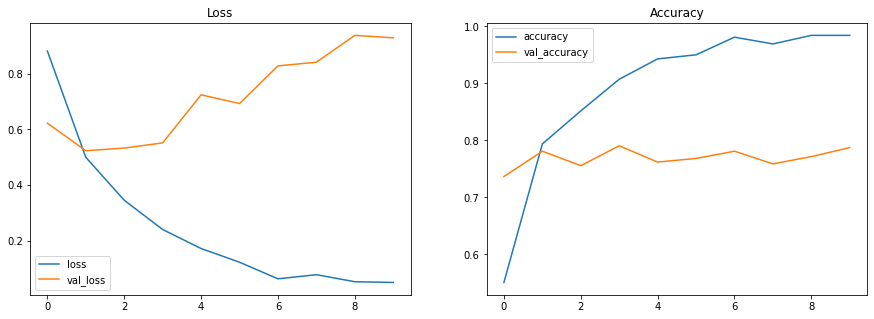

40/40 [==============================] - 4s 102ms/step - loss: 0.9289 - accuracy: 0.7873
[0.9289246797561646, 0.7873015999794006]


In [74]:
############################
# Training Params
############################
learning_rate = 2e-5
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

**Finetune** a language model using the the abstract texts provided (abstracts_train.txt & datasets/abstracts_validate.txt).

In [75]:
models_metrics_list = glob("experiment_*/*_model_metrics.json")
models_metrics_list

['experiment_1634160360/simple_fcn_emb_model_metrics.json',
 'experiment_1634160854/conv1d_pretrained_emb_model_metrics.json',
 'experiment_1634160606/conv1d_emb_model_metrics.json',
 'experiment_1634160354/simple_fcn_model_metrics.json',
 'experiment_1634162006/bert_pretrained_model_metrics.json',
 'experiment_1634161476/bert_pretrained_model_metrics.json']

In [76]:
all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","execution_time","loss",
                             "accuracy","model_size","learning_rate","epochs","name"]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,epochs,name
4,"109,484,547",8.24 mins,0.93,78.73%,438 MB,0.00002,10,bert_pretrained
2,"1,755,739",0.35 mins,1.09,75.87%,7 MB,0.01000,10,conv1d_emb
5,"109,484,547",4.30 mins,0.59,75.56%,438 MB,0.00002,5,bert_pretrained
1,"161,539",0.07 mins,1.06,73.33%,7 MB,0.01000,10,conv1d_pretrained_emb
0,"206,921,563",0.24 mins,3.32,55.87%,828 MB,0.01000,10,simple_fcn_emb
3,"3,887,619",0.08 mins,1.10,31.75%,16 MB,0.01000,10,simple_fcn


## **<font color="#A41034">Submit to Kaggle</font>**

* Make predictions on test datasets
* Prepare `submission.csv` file
* Upload using the [Kaggle](https://www.kaggle.com/c/ac215-fall-2021/submit)

In [148]:
# Tokenize test x
test_x_processed = tokenizer.batch_encode_plus(
        test_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Create TF Dataset
test_data = tf.data.Dataset.from_tensor_slices(((test_x_processed["input_ids"],
                                                  test_x_processed["token_type_ids"],
                                                  test_x_processed["attention_mask"])))

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

print("test_data",test_data)
# Make predictions
print("test_data_length", len(test_data))


test_data <TensorSliceDataset shapes: ((256,), (256,), (256,)), types: (tf.int32, tf.int32, tf.int32)>
test_data_length 525


In [166]:
# Make predictions
predictions = model.predict(test_data)
predicted_class = predictions.logits.argmax(axis=1).astype(int)
df = pd.DataFrame.from_dict({"id": [i for i in range(0,525)], "target": predicted_class})
df.to_csv('submission.csv',index=False)

## **<font color="#A41034">Kaggle Team Name</font>**

Please provide your **Team Name** to Kaggle that you used to make your submissions. 

Orcas


**Fine Tune**

In [183]:
file = open("./datasets/abstracts_train.txt")
file_contents = file.read()
contents_split = file_contents.split("\n\n")
df_train = pd.DataFrame.from_dict({"train_x": contents_split})
df_train.to_csv('abstracts_train.csv',index=False)

In [185]:
file = open("./datasets/abstracts_validate.txt")
file_contents = file.read()
contents_split = file_contents.split("\n\n")
df_train = pd.DataFrame.from_dict({"validate_x": contents_split})
df_train.to_csv('abstracts_validate.csv',index=False)

In [188]:
! python ./finetune/run_mlm.py --model_name_or_path ./experiment_1634162006/bert_pretrained.h5 --output_dir ./output --train_file ./datasets/abstracts_train.csv --validation_file ./datasets/abstracts_validate.csv


2021-10-13 23:24:13.379060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 23:24:13.388680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 23:24:13.388978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 23:24:13.390208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 23:24:13.390506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S